In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import tensorflow as tf  
from sklearn.model_selection import TimeSeriesSplit 
#print('Imported tensorflow', tf.VERSION)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
data = pd.read_csv('/Users/Apple/Desktop/DataX/DeepVuproject/resupplychainoptimizationdataxprojectteam/metals_daily_train.csv', index_col = 'date')
data = data.dropna(axis = 0)
data.head()

,p0,p1,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,f001_low,...,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle,week,week_date
date,,,,,,,,,,,,,,,,,,,,,
20081201,444.511058,457.032497,457.032497,53.08,56.33,52.62,56.29,49.11,52.15,48.62,...,9420.0,9680.0,9315.0,9540.0,9520.0,9800.0,9495.0,9650.0,2030,20081201
20081202,446.908899,465.530103,459.323035,55.99,56.29,54.68,55.30,51.80,52.24,51.04,...,9480.0,9600.0,9430.0,9510.0,9640.0,9730.0,9560.0,9630.0,2030,20081201
20081203,453.484820,482.060575,459.696940,56.50,56.72,54.65,55.21,53.01,53.02,51.21,...,9495.0,9580.0,9400.0,9500.0,9530.0,9690.0,9505.0,9590.0,2030,20081201
20081204,447.532919,472.395859,459.964389,55.50,57.81,54.88,57.62,51.75,54.42,51.60,...,9485.0,9485.0,9120.0,9145.0,9400.0,9445.0,9205.0,9225.0,2030,20081201
20081205,447.084228,471.922241,459.503235,58.50,60.00,56.63,56.75,54.70,56.18,53.45,...,8710.0,9000.0,8595.0,8665.0,8885.0,8940.0,8670.0,8715.0,2030,20081201


In [4]:
def df_shift(df, lag, predict_name_column):
    ### takes a data frame, shifts column to be predicted by a lag ###
    columns_features = list(df.columns)
    columns_features.remove(predict_name_column)
    
    value_to_predict = df.loc[:,predict_name_column]   
    df_shifted = df.copy()
                              
    #df_shifted = pd.DataFrame(index = df.index[lag:]
    
    
    for col in columns_features:
        df_shifted[col] = data.loc[:,col].shift(lag)
    
    
    df_shifted = df_shifted.dropna(axis=0)                        
    return df_shifted
        


In [5]:
## TEST

df_shift(data,2,'p1').head()


,p0,p1,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,f001_low,...,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle,week,week_date
date,,,,,,,,,,,,,,,,,,,,,
20081203,444.511058,482.060575,457.032497,53.08,56.33,52.62,56.29,49.11,52.15,48.62,...,9420.0,9680.0,9315.0,9540.0,9520.0,9800.0,9495.0,9650.0,2030.0,20081201.0
20081204,446.908899,472.395859,459.323035,55.99,56.29,54.68,55.30,51.80,52.24,51.04,...,9480.0,9600.0,9430.0,9510.0,9640.0,9730.0,9560.0,9630.0,2030.0,20081201.0
20081205,453.484820,471.922241,459.696940,56.50,56.72,54.65,55.21,53.01,53.02,51.21,...,9495.0,9580.0,9400.0,9500.0,9530.0,9690.0,9505.0,9590.0,2030.0,20081201.0
20081208,447.532919,472.073147,459.964389,55.50,57.81,54.88,57.62,51.75,54.42,51.60,...,9485.0,9485.0,9120.0,9145.0,9400.0,9445.0,9205.0,9225.0,2030.0,20081201.0
20081209,447.084228,472.134908,459.503235,58.50,60.00,56.63,56.75,54.70,56.18,53.45,...,8710.0,9000.0,8595.0,8665.0,8885.0,8940.0,8670.0,8715.0,2030.0,20081201.0


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [7]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [9]:
def plotModelResults(model, X_train):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_train)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_train.values, label="actual", linewidth=2.0)
        
    
    error = mean_absolute_percentage_error(y_train,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [19]:
def plotFuture(model, X_train):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_train)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [11]:
def ModelResults(model, X_train, X_test):
    
    prediction = model.predict(X_test)
    error = mean_absolute_percentage_error(prediction, y_test)
    print("Mean absolute percentage error {0:.2f}%".format(error))

In [12]:
## shift data set by timelag

data_shifted = df_shift(data, 70, 'p1')
data_shifted.head()

,p0,p1,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,f001_low,...,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle,week,week_date
date,,,,,,,,,,,,,,,,,,,,,
20090327,444.511058,444.107673,457.032497,53.08,56.33,52.62,56.29,49.11,52.15,48.62,...,9420.0,9680.0,9315.0,9540.0,9520.0,9800.0,9495.0,9650.0,2030.0,20081201.0
20090330,446.908899,444.146679,459.323035,55.99,56.29,54.68,55.30,51.80,52.24,51.04,...,9480.0,9600.0,9430.0,9510.0,9640.0,9730.0,9560.0,9630.0,2030.0,20081201.0
20090331,453.484820,443.854306,459.696940,56.50,56.72,54.65,55.21,53.01,53.02,51.21,...,9495.0,9580.0,9400.0,9500.0,9530.0,9690.0,9505.0,9590.0,2030.0,20081201.0
20090401,447.532919,444.023185,459.964389,55.50,57.81,54.88,57.62,51.75,54.42,51.60,...,9485.0,9485.0,9120.0,9145.0,9400.0,9445.0,9205.0,9225.0,2030.0,20081201.0
20090402,447.084228,443.971209,459.503235,58.50,60.00,56.63,56.75,54.70,56.18,53.45,...,8710.0,9000.0,8595.0,8665.0,8885.0,8940.0,8670.0,8715.0,2030.0,20081201.0


In [13]:
## save last lagged values for future prediction
X_future = data.copy().drop('p1', axis=1).drop('week', axis =1).drop('week_date', axis=1).iloc[-70:,:]
X_future

,p0,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,f001_low,f001_settle,...,f135_low,f135_settle,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle
date,,,,,,,,,,,,,,,,,,,,,
20180126,541.632107,559.147574,12.570,12.670,12.330,12.475,13.186,13.280,12.990,13.205,...,13765.0,13765.0,26250.0,26310.0,26115.0,26195.0,26225.0,26295.0,26105.0,26180.0
20180129,543.078925,560.641179,12.650,13.700,12.580,13.645,13.360,14.030,13.276,14.005,...,13725.0,13775.0,26315.0,27235.0,26200.0,26835.0,26290.0,27750.0,26185.0,26805.0
20180130,542.692923,560.242694,13.730,14.594,13.674,14.035,14.120,14.760,14.084,14.315,...,13665.0,13665.0,27065.0,27130.0,26700.0,26915.0,27000.0,27085.0,26650.0,26865.0
20180131,538.413365,560.003875,14.030,14.178,13.530,13.635,14.378,14.520,13.956,14.075,...,13125.0,13125.0,26900.0,26915.0,26520.0,26715.0,26900.0,26900.0,26510.0,26700.0
20180201,547.702665,562.615362,13.690,14.000,13.000,13.425,14.170,14.440,13.630,13.925,...,13030.0,13085.0,26740.0,26825.0,26630.0,26730.0,26745.0,26795.0,26595.0,26705.0
20180202,551.814498,564.046839,13.400,15.000,13.080,14.975,13.920,15.100,13.630,15.075,...,13010.0,13010.0,26730.0,26950.0,26630.0,26800.0,26705.0,26935.0,26615.0,26790.0
20180205,553.353669,562.847482,15.000,29.250,14.430,27.975,15.100,28.050,14.650,24.725,...,12895.0,12965.0,26780.0,26840.0,26540.0,26715.0,26740.0,26825.0,26525.0,26705.0
20180206,552.888681,562.374516,27.400,28.000,18.100,21.025,17.200,25.190,17.200,20.000,...,12600.0,12675.0,26795.0,27000.0,26420.0,26705.0,26800.0,26995.0,26410.0,26690.0
20180207,554.559252,564.073749,20.450,20.900,17.800,19.875,19.640,19.950,17.740,19.350,...,12780.0,12780.0,26535.0,26690.0,26440.0,26555.0,26510.0,26685.0,26435.0,26550.0


In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = data_shifted.p1
x = data_shifted.drop('p1', axis=1).drop('week', axis=1).drop('week_date', axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(x, y, test_size=0)

X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.fit_transform(X_test)

In [15]:
xgb = XGBRegressor()

In [16]:
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

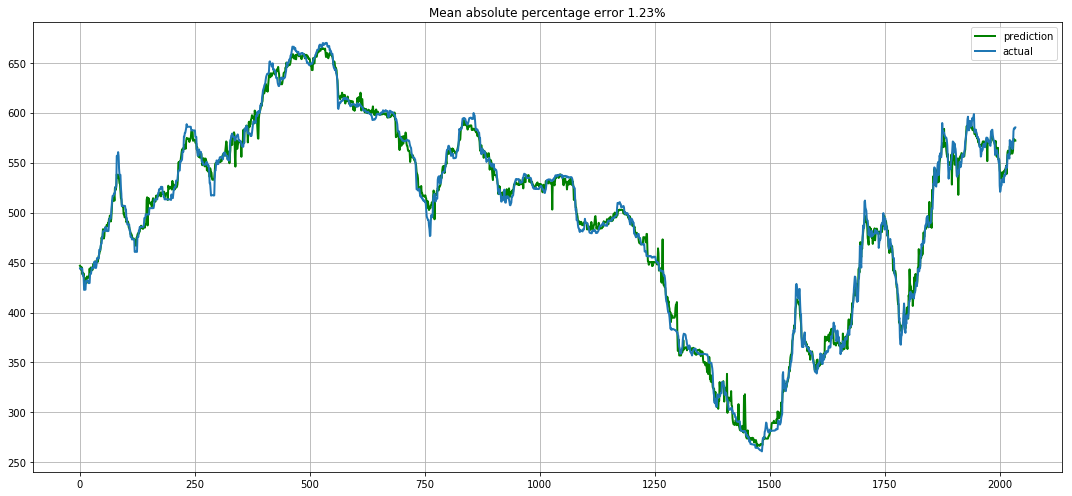

In [17]:
## plot performance on test data 

#ModelResults(xgb, X_train=X_train_scaled, X_test=X_test_scaled)
plotModelResults(xgb, X_train=X_train_scaled)

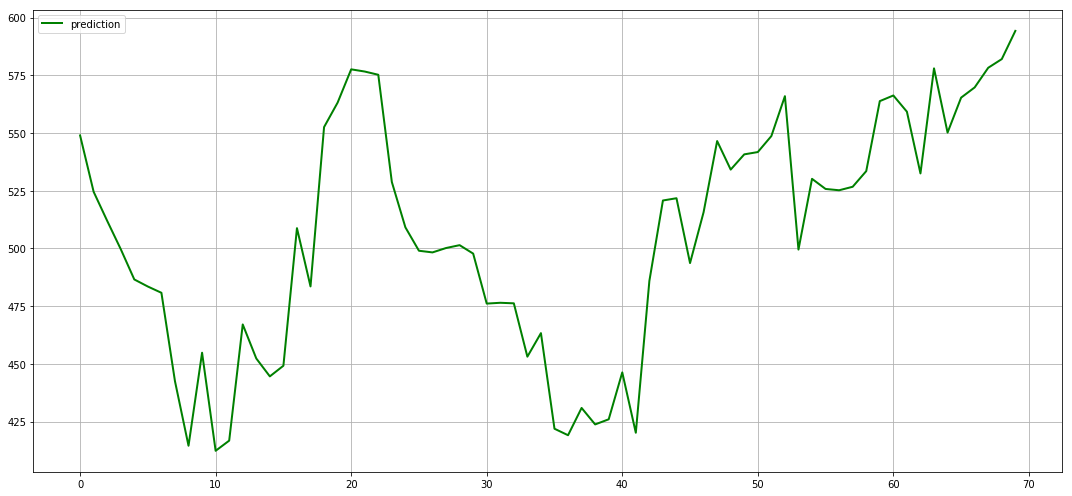

In [18]:
## predict future values and plot performance

X_future_scaled = scaler.fit_transform(X_future)

plotFuture(xgb, X_train=X_future_scaled)